In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
#assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
#assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.model.DHDSTformer import DHDSTformer, DHDSTformer2, DHDSTformer3, DHDSTformer_limb, DHDSTformer_torso

def parse_args(target):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_baseline.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args([
        '--config', 'configs/pose3d/{}.yaml'.format(target),
        '--evaluate', 'checkpoint/pose3d/{}/best_epoch.bin'.format(target)])
    return opts

def get_h36m_camera_info(subject, action, camera_id):
    cam_info = h36m_3d_world._data[subject][action]['cameras']
    cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
    calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
    R = np.array(cam_param[camera_id]['ext']['R'])
    t = np.array(cam_param[camera_id]['ext']['t'])/1000
    H = cam_param[camera_id]['H']
    W = cam_param[camera_id]['W']
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 
    return calibration_matrix, camera_param, H, W, fx, fy, cx, cy

def data_processing(pose3d_list, camera_param, fx, fy, cx, cy, length=243):
    pose_2d_list = []
    cam_3d_list = []
    img_3d_list = []
    img_3d_hat_list = []
    img_25d_list = []
    scale_list = []
    for frame_num in range(len(pose3d_list[:length])):
        world_3d = np.array(pose3d_list[frame_num])
        # world to camera
        pos = copy.deepcopy(world_3d)
        cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
        cam_3d_hat = get_rootrel_pose(cam_3d)

        # camera to image
        box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 
        # 2.5d factor
        pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
        # joint 2.5d image
        img_25d = img_3d * pred_lambda

        pose_2d_list.append(img_2d)
        cam_3d_list.append(cam_3d)
        img_3d_list.append(img_3d)
        img_3d_hat_list.append(img_3d_hat)
        img_25d_list.append(img_25d)
        scale_list.append(pred_lambda)

    pose_2d_list = np.array(pose_2d_list)
    pose_2d_list = np.append(pose_2d_list, np.ones((pose_2d_list.shape[0], pose_2d_list.shape[1], 1)), axis=2)
    cam_3d_list = np.array(cam_3d_list)
    img_3d_list = np.array(img_3d_list)
    img_3d_hat_list = np.array(img_3d_hat_list)
    img_25d_list = np.array(img_25d_list)
    scale_list = np.array(scale_list)

    return pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list

def get_custom_camera_info(camera):
    calibration_matrix = camera.intrinsic
    R = camera.R
    t = camera.t/1000
    H = camera.IMAGE_HEIGHT
    W = camera.IMAGE_WIDTH
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 
    return calibration_matrix, camera_param, H, W, fx, fy, cx, cy

def mpjpe(predicted, target):
    """
    Mean per-joint position error (i.e. mean Euclidean distance),
    often referred to as "Protocol #1" in many papers.
    """
    assert predicted.shape == target.shape
    return np.mean(np.linalg.norm(predicted - target, axis=len(target.shape)-1), axis=1)

#### Load H36M Dataset

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [10]:
subject = 'S5'
action = 'Walking 1'
camera_id = '54138969'
length = 1000
target_video = f'{subject}_{action}_{camera_id}'

pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_h36m_camera_info(subject, action, camera_id)

pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = data_processing(pose3d_list.copy(), camera_param, fx, fy, cx, cy, length=length)
pose_2d_list = normalize_input(pose_2d_list, 1000, 1000)
pose_2d_list = torch.tensor(pose_2d_list).cuda().unsqueeze(0)
cam_3d_list = torch.tensor(cam_3d_list).cuda().unsqueeze(0)
img_3d_list = torch.tensor(img_3d_list).cuda().unsqueeze(0)
img_3d_hat_list = torch.tensor(img_3d_hat_list).cuda().unsqueeze(0)
img_25d_list = torch.tensor(img_25d_list).cuda().unsqueeze(0)

In [11]:
pose_2d_list

tensor([[[[ 2.8979e-02, -9.7389e-02,  2.0000e-03],
          [ 8.1846e-02, -1.0281e-01,  2.0000e-03],
          [ 6.5027e-02,  9.4037e-02,  2.0000e-03],
          ...,
          [ 1.0494e-01, -2.9620e-01,  2.0000e-03],
          [ 2.1428e-01, -2.6641e-01,  2.0000e-03],
          [ 3.0799e-01, -2.7130e-01,  2.0000e-03]],

         [[ 2.8982e-02, -9.7403e-02,  2.0000e-03],
          [ 8.1821e-02, -1.0282e-01,  2.0000e-03],
          [ 6.5011e-02,  9.4028e-02,  2.0000e-03],
          ...,
          [ 1.0494e-01, -2.9625e-01,  2.0000e-03],
          [ 2.1417e-01, -2.6665e-01,  2.0000e-03],
          [ 3.0760e-01, -2.7159e-01,  2.0000e-03]],

         [[ 2.9003e-02, -9.7417e-02,  2.0000e-03],
          [ 8.1815e-02, -1.0283e-01,  2.0000e-03],
          [ 6.4988e-02,  9.4016e-02,  2.0000e-03],
          ...,
          [ 1.0496e-01, -2.9635e-01,  2.0000e-03],
          [ 2.1407e-01, -2.6690e-01,  2.0000e-03],
          [ 3.0720e-01, -2.7181e-01,  2.0000e-03]],

         ...,

         [[ 3.45

In [53]:
scaled_by_frobenius = batch_input.clone()
scaled_by_frobenius[:, :, :, :2] = (scaled_by_frobenius[:, :, :, :2] + torch.tensor([1, 1]).cuda()) * 1000 / 2
#scaled_by_frobenius[:, :, :, 2:] = scaled_by_frobenius[:, :, :, 2:] * 1000 / 2
denormalized = scaled_by_frobenius.clone()
scaled_by_frobenius = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
scale = torch.norm(scaled_by_frobenius.reshape(-1, 34), dim=1, keepdim=True)
scaled_by_frobenius = (scaled_by_frobenius.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)

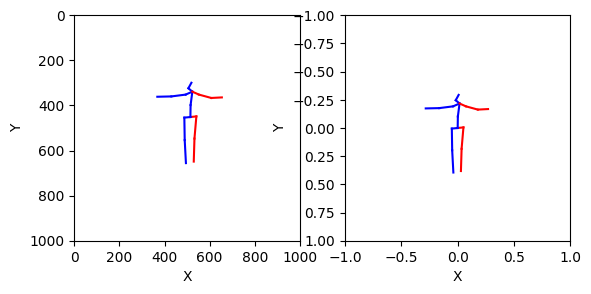

In [54]:
fig = plt.figure(10)
fig.clear()
ax = axes_2d(fig, loc=121, W=1000, H=1000)
ax2 = axes_2d(fig, loc=122, normalize=True)
draw_2d_pose(ax, denormalized[0, 0])
draw_2d_pose(ax2, scaled_by_frobenius[0, 0], normalize=True)

In [28]:
canonical_input2 = scaled_by_frobenius.clone().cpu().detach().numpy().reshape(-1, 34)
scale = np.linalg.norm(canonical_input2, ord=2, axis=1, keepdims=True)
canonical_input2 /= scale
canonical_input2 = canonical_input2.reshape(1, -1, 17, 2)

In [58]:
batch_input = pose_2d_list.clone()[:, :, :, :2]
# root centered
root_centered = batch_input.clone() - batch_input[:, :, 0:1]
# scaled by euclidean
scaled_by_frobenius = batch_input.clone()
scaled_by_frobenius_denormalized = batch_input.clone()
scaled_by_frobenius_denormalized[:, :, :, :2] = (scaled_by_frobenius_denormalized[:, :, :, :2] + torch.tensor([1, 1]).cuda()) * 1000 / 2
scaled_by_frobenius = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
scaled_by_frobenius_denormalized = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
scale = torch.norm(scaled_by_frobenius.reshape(-1, 34), dim=1, keepdim=True)
scale_denormalized = torch.norm(scaled_by_frobenius_denormalized.reshape(-1, 34), dim=1, keepdim=True)
scaled_by_frobenius = (scaled_by_frobenius.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
scaled_by_frobenius_denormalized = (scaled_by_frobenius_denormalized.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
# scaled by each height
batch_height = root_centered[:, :, :, 1].max(dim=-1).values - root_centered[:, :, :, 1].min(dim=-1).values
batch_ratio = torch.ones_like(batch_height) / batch_height
scaled_by_each_height = root_centered.clone() * batch_ratio.unsqueeze(-1).unsqueeze(-1)
# scaled by first height
first_height = batch_height.max()
ratio = torch.ones_like(first_height) / first_height
scaled_by_fixed_height = root_centered.clone() * ratio.unsqueeze(-1).unsqueeze(-1)

original_input = batch_input.cpu().detach().numpy()
canonical_input1 = root_centered.clone().cpu().detach().numpy()
canonical_input2 = scaled_by_frobenius.clone().cpu().detach().numpy()
canonical_input3 = scaled_by_each_height.clone().cpu().detach().numpy()
canonical_input4 = scaled_by_fixed_height.clone().cpu().detach().numpy()
canonical_input5 = scaled_by_frobenius_denormalized.clone().cpu().detach().numpy()

In [75]:
# target = 'MB_ft_h36m'

# opts = parse_args(target=target)
# args = get_config(opts.config)
# print(opts.evaluate)

# if 'DHDST2' in opts.evaluate:
#     model_pos = DHDSTformer2(chk_filename='', args=args)
# elif 'DHDST_torso' in opts.evaluate:
#     model_pos = DHDSTformer_torso(chk_filename='', args=args)
# elif 'DHDST_limb' in opts.evaluate:
#     model_pos = DHDSTformer_limb(chk_filename='', args=args)
# elif 'MB' in opts.evaluate:
#     model_pos = load_backbone(args)
    
# model_pos = nn.DataParallel(model_pos)
# model_pos = model_pos.cuda()
# checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
# model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
# model_pos = model_pos.eval()

# args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
# args.subset_list = ['H36M-SH']
# datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
# testloader_params = {
#         'batch_size': args.batch_size,
#         'shuffle': False,
#         'num_workers': 12,
#         'pin_memory': True,
#         'prefetch_factor': 4,
#         'persistent_workers': True
# }
# test_dataset = MotionDataset3D(args, args.subset_list, 'test')
# test_loader = DataLoader(test_dataset, **testloader_params)


In [76]:
# with torch.no_grad():
#     for batch_input, batch_gt in tqdm(test_loader):
#         if torch.cuda.is_available():
#             batch_input = batch_input.cuda()[:, :, :, :2]
#             batch_gt = batch_gt.cuda()
#         break

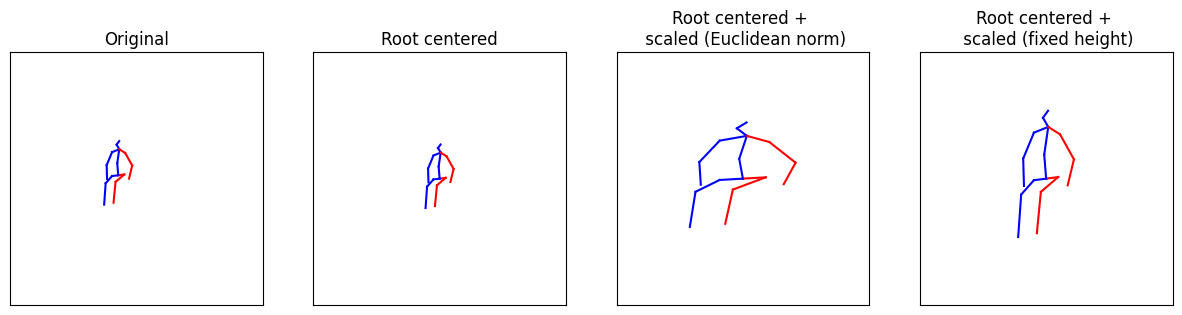

In [96]:
# visualize
batch_num = 0
frame_num = 150

%matplotlib inline
fig = plt.figure(0, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCD
    """,
    #per_subplot_kw={('A'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
#axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)

axA.set_title('Original')
axB.set_title('Root centered')
axC.set_title('Root centered + \n scaled (Euclidean norm)')
axD.set_title('Root centered + \n scaled (fixed height)')

draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5bde900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1000/1000 [00:40<00:00, 24.60it/s]


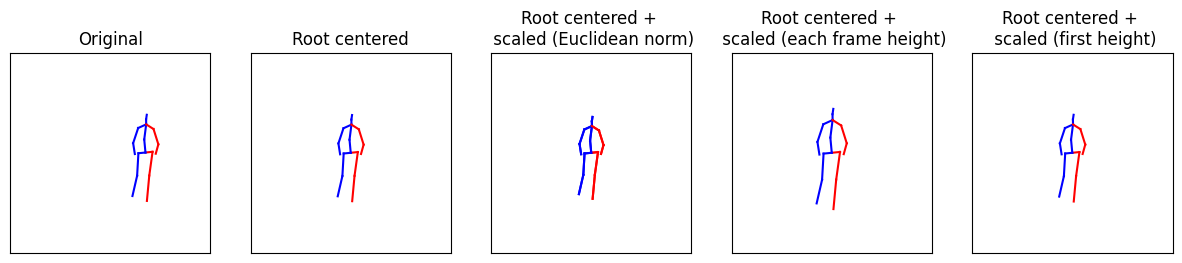

In [59]:
batch_num = 0

%matplotlib inline
fig = plt.figure(0, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCDE
    """,
    #per_subplot_kw={('A'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)

axA.set_title('Original')
axB.set_title('Root centered')
axC.set_title('Root centered + \n scaled (Euclidean norm)')
axD.set_title('Root centered + \n scaled (each frame height)')
axE.set_title('Root centered + \n scaled (first height)')

videowriter = imageio.get_writer(f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_input_type_{subject}_{action}_{camera_id}.mp4', fps=30)
for frame_num in tqdm(range(length)):
    clear_axes([axA, axB, axC, axD, axE])
    draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
    draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
    draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
    draw_2d_pose(axC, canonical_input5[batch_num, frame_num], normalize=True)
    draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
    draw_2d_pose(axE, canonical_input4[batch_num, frame_num], normalize=True)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
    videowriter.append_data(image_from_plot)
videowriter.close()

Waiting 1


  0%|          | 0/1440 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a47900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1440/1440 [00:46<00:00, 31.20it/s]


Photo 1


  0%|          | 0/1074 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55db900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1074/1074 [00:34<00:00, 31.15it/s]


Smoking


  0%|          | 0/2478 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x691f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2478/2478 [01:25<00:00, 28.87it/s]


Eating 2


  0%|          | 0/2357 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6326900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2357/2357 [01:18<00:00, 30.21it/s]


WalkTogether 1


  0%|          | 0/1275 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5bcf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1275/1275 [00:42<00:00, 30.04it/s]


Greeting 1


  0%|          | 0/1265 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6eaf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1265/1265 [00:42<00:00, 30.06it/s]


Phoning


  0%|          | 0/2266 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7437900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2266/2266 [01:13<00:00, 30.73it/s]


Phoning 1


  0%|          | 0/2636 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x622a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2636/2636 [01:24<00:00, 31.08it/s]


Smoking 1


  0%|          | 0/2611 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6fe1900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2611/2611 [01:25<00:00, 30.65it/s]


Discussion 1


  0%|          | 0/3805 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f72900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3805/3805 [02:05<00:00, 30.38it/s]


WalkTogether


  0%|          | 0/1231 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d6a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1231/1231 [00:39<00:00, 31.16it/s]


Sitting 1


  0%|          | 0/3304 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x67bc900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3304/3304 [01:48<00:00, 30.43it/s]


SittingDown


100%|██████████| 2742/2742 [01:30<00:00, 30.38it/s]


Directions


  0%|          | 0/1612 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ff8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1612/1612 [00:53<00:00, 30.31it/s]


Directions 1


  0%|          | 0/1383 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7209900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1383/1383 [00:45<00:00, 30.39it/s]


Purchases


  0%|          | 0/1158 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60ed900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1158/1158 [00:37<00:00, 30.86it/s]


SittingDown 2


  0%|          | 0/3023 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f02900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3023/3023 [01:39<00:00, 30.39it/s]


Walking 1


  0%|          | 0/3476 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x572b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3476/3476 [01:52<00:00, 31.00it/s]


WalkDog 1


  0%|          | 0/1662 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5dcf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1662/1662 [00:54<00:00, 30.64it/s]


Waiting


  0%|          | 0/1792 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x67e3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1792/1792 [00:59<00:00, 30.28it/s]


Walking


  0%|          | 0/3134 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5c65900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3134/3134 [01:41<00:00, 30.92it/s]


Discussion


  0%|          | 0/3852 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7216900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3852/3852 [02:05<00:00, 30.78it/s]


Eating


100%|██████████| 2721/2721 [01:27<00:00, 31.08it/s]


Posing


100%|██████████| 992/992 [00:32<00:00, 30.27it/s]


Greeting


  0%|          | 0/1149 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f36900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1149/1149 [00:37<00:00, 30.95it/s]


Posing 1


  0%|          | 0/1167 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6aa7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1167/1167 [00:38<00:00, 30.45it/s]


WalkDog


  0%|          | 0/1777 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5648900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1777/1777 [00:58<00:00, 30.31it/s]


Photo


  0%|          | 0/1036 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e28900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1036/1036 [00:34<00:00, 30.45it/s]


Purchases 1


  0%|          | 0/1064 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x734f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1064/1064 [00:34<00:00, 30.67it/s]


Sitting 2


  0%|          | 0/2612 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f12900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2612/2612 [01:24<00:00, 31.06it/s]


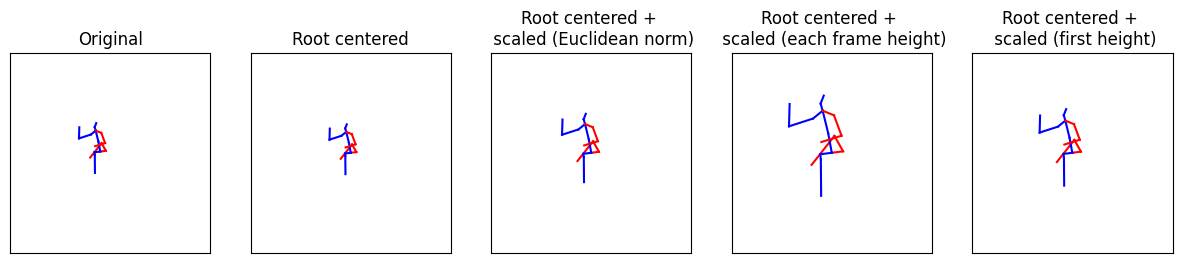

In [6]:
subject = 'S1'
for action in h36m_3d_world._data[subject].keys():
    print(action)
    camera_id = '54138969'
    
    target_video = f'{subject}_{action}_{camera_id}'

    pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
    length = len(pose3d_list)
    calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_h36m_camera_info(subject, action, camera_id)

    pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = data_processing(pose3d_list.copy(), camera_param, fx, fy, cx, cy, length=length)
    pose_2d_list = normalize_input(pose_2d_list, 1000, 1000)
    pose_2d_list = torch.tensor(pose_2d_list).cuda().unsqueeze(0)
    cam_3d_list = torch.tensor(cam_3d_list).cuda().unsqueeze(0)
    img_3d_list = torch.tensor(img_3d_list).cuda().unsqueeze(0)
    img_3d_hat_list = torch.tensor(img_3d_hat_list).cuda().unsqueeze(0)
    img_25d_list = torch.tensor(img_25d_list).cuda().unsqueeze(0)

    # inputs
    batch_input = pose_2d_list.clone()[:, :, :, :2]
    root_centered = batch_input.clone() - batch_input[:, :, 0:1]
    scaled_by_frobenius = root_centered.clone()
    batch_height = root_centered[:, :, :, 1].max(dim=-1).values - root_centered[:, :, :, 1].min(dim=-1).values
    batch_ratio = torch.ones_like(batch_height) / batch_height
    scaled_by_each_height = root_centered.clone() * batch_ratio.unsqueeze(-1).unsqueeze(-1)
    first_height = batch_height.max()
    ratio = torch.ones_like(first_height) / first_height
    scaled_by_fixed_height = root_centered.clone() * ratio.unsqueeze(-1).unsqueeze(-1)

    original_input = batch_input.cpu().detach().numpy()
    canonical_input1 = root_centered.clone().cpu().detach().numpy()
    canonical_input2 = scaled_by_frobenius.clone().cpu().detach().numpy().reshape(-1, 34)
    scale = np.linalg.norm(canonical_input2, ord=2, axis=1, keepdims=True)
    canonical_input2 /= scale
    canonical_input2 = canonical_input2.reshape(1, -1, 17, 2)
    canonical_input3 = scaled_by_each_height.clone().cpu().detach().numpy()
    canonical_input4 = scaled_by_fixed_height.clone().cpu().detach().numpy()

    # save video
    batch_num = 0

    %matplotlib inline
    fig = plt.figure(0, figsize=(15, 5))
    fig.clear()
    axd = fig.subplot_mosaic(
        """
        ABCDE
        """,
        #per_subplot_kw={('A'): {'projection': '3d'}}
    )

    axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
    axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
    axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
    axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
    axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)

    axA.set_title('Original')
    axB.set_title('Root centered')
    axC.set_title('Root centered + \n scaled (Euclidean norm)')
    axD.set_title('Root centered + \n scaled (each frame height)')
    axE.set_title('Root centered + \n scaled (first height)')

    videowriter = imageio.get_writer(f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_input_type_{subject}_{action}_{camera_id}.mp4', fps=30)
    for frame_num in tqdm(range(length)):
        clear_axes([axA, axB, axC, axD, axE])
        draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
        draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
        draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
        draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
        draw_2d_pose(axE, canonical_input4[batch_num, frame_num], normalize=True)
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        image_from_plot = np.array(canvas.renderer._renderer)
        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
        videowriter.append_data(image_from_plot)
    videowriter.close()

In [16]:
batch_num = -1
videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/canonical_test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized_with_canonical[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x617cdc0] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73addc0] Warning: data is not aligned! This can lead to a speed loss
